# Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. 

In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys
sys.path.append('../')
from lib.builders import age01 as b1
import lib.drawMaps as draw


There are default parameters that I've chosen as the best fit for creating a _'believable'_ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 

In [2]:
b1.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1}

In [3]:
landscape = b1.Landscape()

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

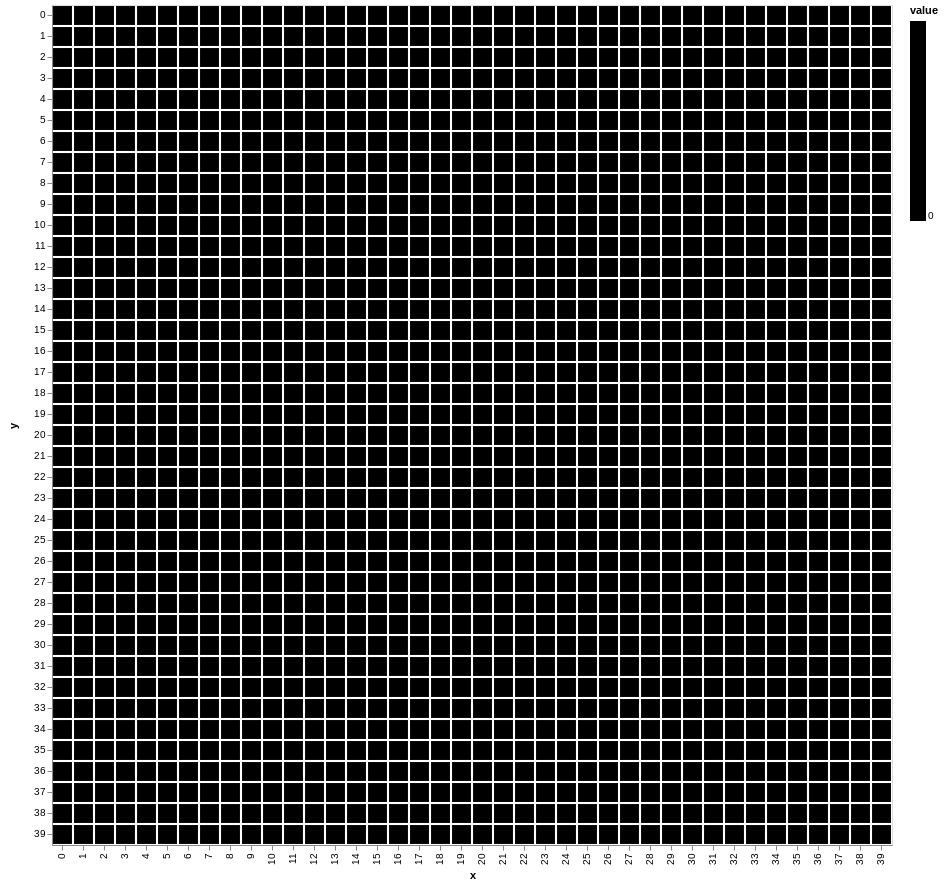

In [4]:
world = b1.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated proceduraly. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

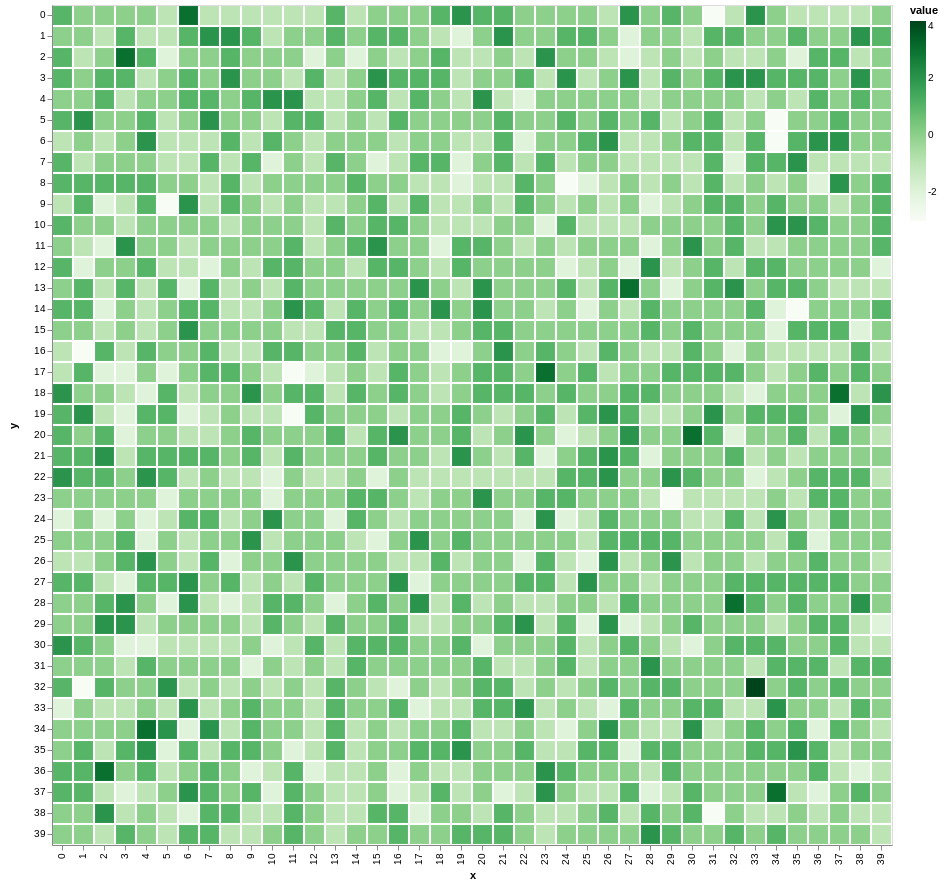

In [5]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [6]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symetrically.

In [7]:
c = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", c)

mdf = world.reindexMountain(c,m)
mdf

Mountain Placed:  [15 10]


,6,7,8,9,10,11,12,13,14
11,1,1,1,1,1,1,1,1,1
12,1,2,2,2,2,2,2,2,1
13,1,2,3,3,3,3,3,2,1
14,1,2,3,4,4,4,3,2,1
15,1,2,3,4,5,4,3,2,1
16,1,2,3,4,4,4,3,2,1
17,1,2,3,3,3,3,3,2,1
18,1,2,2,2,2,2,2,2,1
19,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

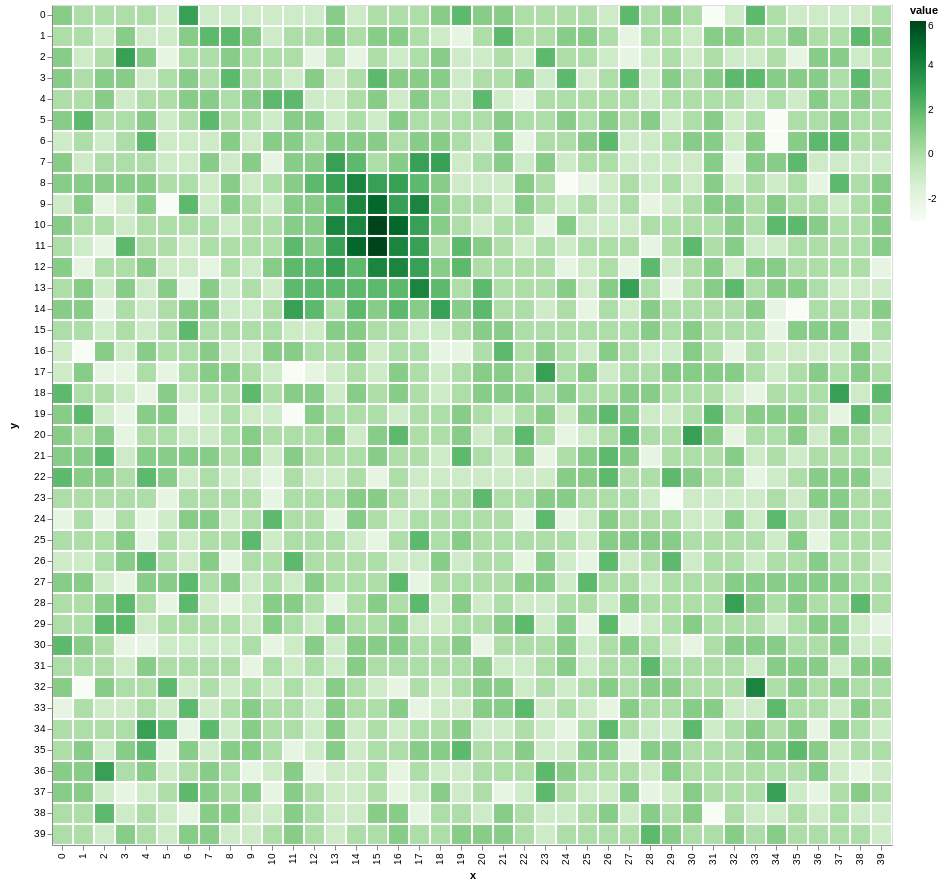

In [8]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board (like Sim City) I'll need to create a brownian motion function to drop a mountain and then move. 

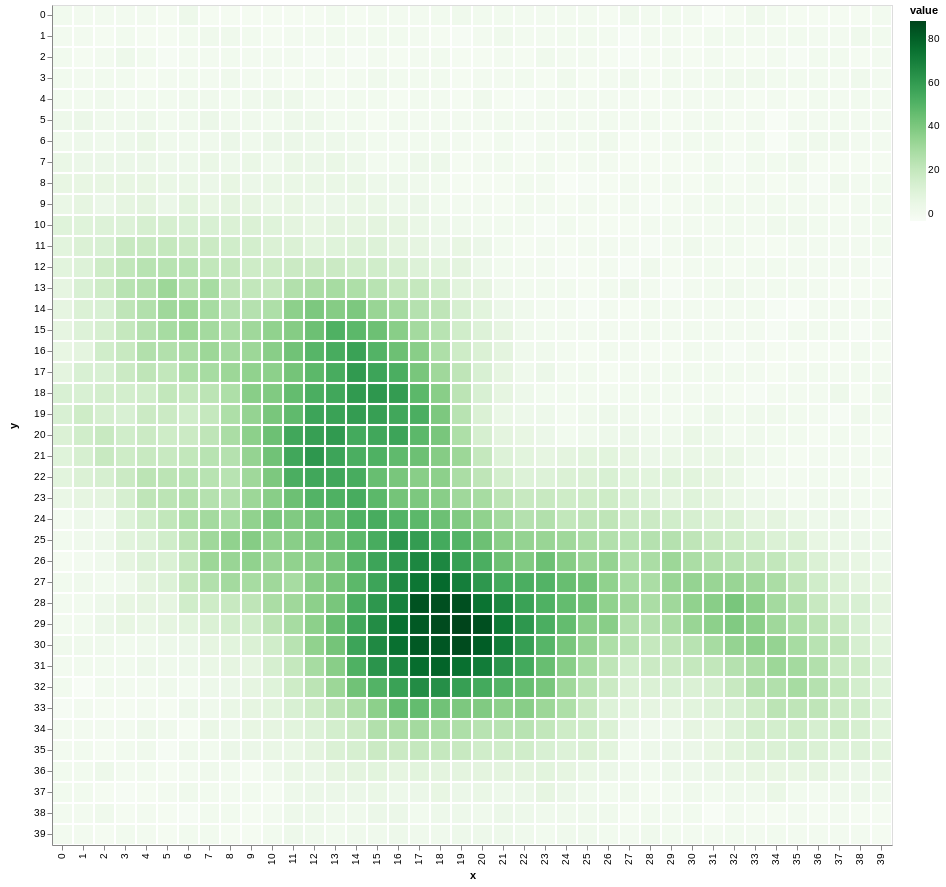

In [9]:
world.brownian_land()
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `heignt == 0` then you can assume that lower terrain is _under water_

In [10]:
draw.drawTerrainTypes(world.grid_elevation)

TypeError: drawTerrainTypes() missing 1 required positional argument: 'landscape'

### Rivers

The idea of rivers is to start at the top of a mountain and flow down to the sea. 

In [11]:
def brownian_rainfall(df,landscape):
    df_new = df.copy()
    for n in range(landscape['rain_iter']):
        coord = get_random_chord(df_new)
        landscape['peaks'].append(coord)
        for m in range(landscape['rain_spread']):
            try:
                coord = get_next_coord(coord)
                m = getMountain(height=abs(
                                        int(np.round(
                                            np.random.normal(landscape['mt_avg'], landscape['mt_std']))
                                              )))
                mdf = reindexMountain(coord,m)
                df_new = df_new.add(mdf.reindex_like(df_new).fillna(0))
            except:
                continue
    return df_new

#land Specifications
landscape['peak_height'] = 5

landscape['mt_avg'] = 2
landscape['mt_std'] = 3

landscape['rain_iter'] = 8 #number of times a terain item will be dropped
landscape['rain_spread'] = 1000 #number of times a dropped item will spread out (affects land mass size)


rainfall = brownian_land(oceanworld,landscape)

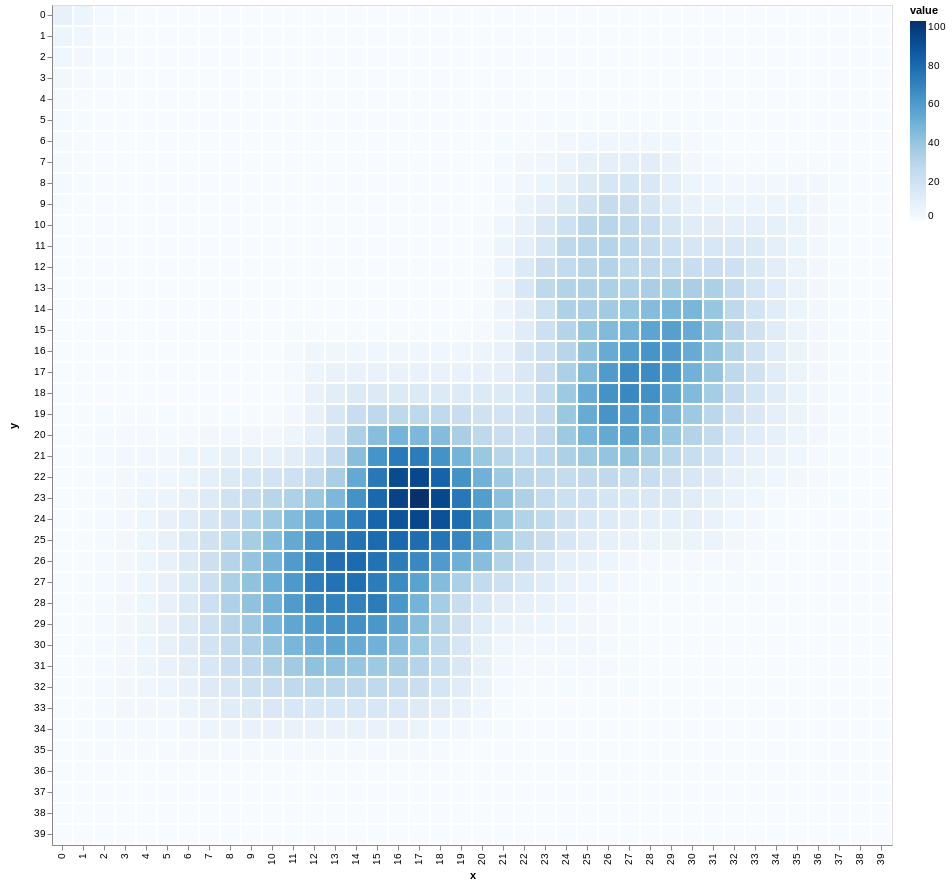

In [12]:
### Rivers
draw.drawRainFall(rainfall)

In [13]:
df = draw.meltMap(rainfall).rename(columns={'value':'water'})
df['mountain height'] = draw.meltMap(mountainLand)['value']
df.sort_values('mountain height').tail()


,y,water,x,mountain height
key,,,,
38:38,38,0.0,38,62.0
36:39,39,0.0,36,67.0
39:39,39,0.0,39,67.0
38:39,39,0.0,38,78.0
37:39,39,0.0,37,79.0


In [14]:
#TODO: This is isn't exactly right, the resulting dataframe is lopsided and not perfectly centered. 
def git_local_Maximum(coord,df,depth,verbose=False):
    mini = df.iloc[coord[0]-depth:coord[0]+(depth+1),coord[1]-depth:coord[1]+(depth+1)]
    newCoord = mini.stack().index[np.argmax(mini.values)]
    if verbose:
        print(coord)
        print(mini)
    return np.array(newCoord)

mini = git_local_Maximum(landscape['peaks'][3],mountainLand,depth=3,verbose=True)
mini

[12 28]
      25    26    27    28    29    30    31
9   32.0  44.0  49.0  46.0  41.0  32.0  25.0
10  28.0  39.0  43.0  43.0  38.0  30.0  25.0
11  23.0  29.0  33.0  35.0  32.0  29.0  27.0
12  16.0  19.0  22.0  25.0  25.0  27.0  32.0
13   8.0  10.0  13.0  16.0  19.0  24.0  32.0
14   3.0   5.0   8.0  11.0  14.0  21.0  31.0
15   1.0   3.0   6.0   9.0  11.0  18.0  28.0


array([ 9, 27])

# Running rivers

In [15]:
def git_local_Minimum(coord,df,depth):
    mini = df.iloc[coord[0]-depth:coord[0]+(depth+1),coord[1]-depth:coord[1]+depth+2]
    newCoord = mini.stack().index[np.argmax(mini.values)]
    return mini

git_local_Minimum(mini,mountainLand,depth=1)

,26,27,28,29
8,43.0,50.0,49.0,44.0
9,44.0,49.0,46.0,41.0
10,39.0,43.0,43.0,38.0


In [16]:
df = draw.meltMap(rainfall,value='rainfall').rename(columns={'value':'water'})
df['key'] = df.index

df['x'] = df['key'].apply(lambda x: int(str(x).split(":")[0]))
df['y'] = df['key'].apply(lambda x: int(str(x).split(":")[1]))
df['elevation'] = draw.meltMap(mountainLand)['value']
df['terrain'] = df['elevation'].apply(lambda x: draw.landTypes(x,landscape=landscape))
df

,y,rainfall,x,key,elevation,terrain
key,,,,,,
0:0,0,8.0,0,0:0,0.0,ocean
1:0,0,5.0,1,1:0,0.0,ocean
2:0,0,2.0,2,2:0,0.0,ocean
3:0,0,1.0,3,3:0,0.0,ocean
4:0,0,0.0,4,4:0,0.0,ocean
5:0,0,0.0,5,5:0,0.0,ocean
6:0,0,0.0,6,6:0,0.0,ocean
7:0,0,0.0,7,7:0,0.0,ocean
8:0,0,0.0,8,8:0,0.0,ocean


In [17]:
world = {"landscape":landscape,
        "df":df}

with open('world_1.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)